# Product Demand Forecasting

### Import Modules

In [1]:
from __future__  import print_function, division
import datetime
import pandas as pd
import numpy as np
import requests
#import cpi
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy
import copy
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

Recall that the original Columns are:

Product_Code - The product name encoded  
Warehouse - Warehouse name encoded  
Product_Category - Product Category for each Product_Code encoded  
Date - The date **customer** needs the product  
**Order_Demand - single order qty**  

### Import Data 

In [2]:
# Open the pickled cleaned, transformed data
#remember that with is a "messenger" per se

with open('cleaned_product_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

### Inspect Data Characteristics

In [3]:
df.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
0,0993,J,028,2012-07-27,100,2012.0,7.0,30.0,27.0,4.0


In [4]:
df.shape

(1037336, 10)

In [5]:
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
Year                       float64
Month                      float64
Week                       float64
DoM                        float64
DoW                        float64
dtype: object

In [6]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [7]:
df.describe()

,Order_Demand,Year,Month,Week,DoM,DoW
count,1.037336e+06,1.037336e+06,1.037336e+06,1.037336e+06,1.037336e+06,1.037336e+06
mean,4.920153e+03,2.013961e+03,6.507711e+00,2.669375e+01,1.557544e+01,2.022486e+00
std,2.907840e+04,1.389136e+00,3.446122e+00,1.499615e+01,8.800958e+00,1.440601e+00
min,-9.990000e+05,2.011000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.900000e+01,2.013000e+03,3.000000e+00,1.300000e+01,8.000000e+00,1.000000e+00
50%,3.000000e+02,2.014000e+03,7.000000e+00,2.700000e+01,1.600000e+01,2.000000e+00
75%,2.000000e+03,2.015000e+03,1.000000e+01,4.000000e+01,2.300000e+01,3.000000e+00
max,4.000000e+06,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,6.000000e+00


### Need to find the next two categories with the most data

In [8]:
total_order_demand = df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False).sum()
(df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False)/total_order_demand*100).head()


Product_Category
019    82.678857
006     7.869540
005     3.886513
007     2.502538
028     0.926288
Name: Order_Demand, dtype: float64

In [108]:
bigcat = pd.DataFrame(cattotal_order_demand = df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False).sum()
(df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False)/total_order_demand*100).head())

TypeError: 'numpy.int64' object is not callable

In [107]:
bigcat

5103852231

In [9]:
category_demand = df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False).sum()
category_demand


5103852231

In [10]:
#Make copy of dataframe to work with
data = df.copy()
data.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
0,0993,J,028,2012-07-27,100,2012.0,7.0,30.0,27.0,4.0


In [11]:
# we are most interested in `Date` column that contains date of sales; 
data.set_index('Date', inplace=True)

# # sort dates to ascending and view
data.sort_index(inplace=True)

In [12]:
data.head(1)

,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
Date,,,,,,,,,
2011-01-08,0965,A,006,2,2011.0,1.0,1.0,8.0,5.0


### Analysis with Product Category 19 
#### Product Category 19 accounted for 83% of total Order Demand


In [13]:
total_order_demand = df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False).sum()
(df.groupby(['Product_Category']).Order_Demand.sum().sort_values(ascending = False)/total_order_demand*100).head()

Product_Category
019    82.678857
006     7.869540
005     3.886513
007     2.502538
028     0.926288
Name: Order_Demand, dtype: float64

#### Create a continuous list of dates for data date range

In [14]:
#Create a df of ALL DATES between the earliest and latest dates in the data
df_all_dates = pd.DataFrame(pd.date_range(start = '2011-01-08', end = '2017-01-09'))
df_all_dates.head(2)

,0
0,2011-01-08
1,2011-01-09


In [15]:
#Rename the column from 0 to exact same as column in the data set
df_all_dates = df_all_dates.rename({0:'Date'}, axis = 1)
df_all_dates.head(2)

,Date
0,2011-01-08
1,2011-01-09


In [16]:
#Create a separate df for Category 019 data
df_005 = data[data.Product_Category == '005']
df_005.head(1)

,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
Date,,,,,,,,,
2011-12-15,0031,J,005,-100,2011.0,12.0,50.0,15.0,3.0


In [17]:
#Merge Category 19 with all_dates to make one df with full dates
df_005 = df_005.merge(df_all_dates, on = 'Date', how = 'right').\
                    sort_values("Date").reset_index(drop = True)

In [18]:
df_005.head(2)

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
0,2011-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_005.sort_values(by = 'Date')

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
0,2011-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
102360,2017-01-06,0025,J,005,500.0,2017.0,1.0,1.0,6.0,4.0
102361,2017-01-06,0025,J,005,700.0,2017.0,1.0,1.0,6.0,4.0
102362,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102363,2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Remove NaNs from Order_Demand
df_005['Order_Demand'] = df_005['Order_Demand'].fillna(0)
df_005.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
0,2011-01-08,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2011-01-09,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2011-01-10,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2011-01-11,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2011-01-12,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [21]:
#Need one data point for each day so groupby day and sum
#Note that since Order_Demand is the only numeric value this yields two columns
df_005= df_005.reset_index().groupby('Date')['Order_Demand'].agg(sum)
df_005.tail()

Date
2017-01-05    5000.0
2017-01-06    5600.0
2017-01-07       0.0
2017-01-08       0.0
2017-01-09       0.0
Name: Order_Demand, dtype: float64

In [22]:
#Make dataframe of Date and Order Demand
df_005 = pd.DataFrame(df_005)
df_005.tail()

,Order_Demand
Date,
2017-01-05,5000.0
2017-01-06,5600.0
2017-01-07,0.0
2017-01-08,0.0
2017-01-09,0.0


### Subset data by date
Remove 2011 as too many missing values.  
Subset 2016 and later as that will be test data

In [23]:
df_005_train = df_005[(df_005.index >'2012-01-01') & (df_005.index<'2016-01-01')]
df_005_train.head()

,Order_Demand
Date,
2012-01-02,3500.0
2012-01-03,33600.0
2012-01-04,7200.0
2012-01-05,147460.0
2012-01-06,184005.0


In [24]:
df_005_test = df_005[(df_005.index > '2015-12-31')]
df_005_test

,Order_Demand
Date,
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,18000.0
2016-01-04,300900.0
2016-01-05,220200.0
...,...
2017-01-05,5000.0
2017-01-06,5600.0
2017-01-07,0.0


### Resample the data by week, biweek, and month

In [25]:
#resample by week
df_005_weekly = df_005_train.resample('W').sum()

In [26]:
#train_index


In [27]:
len(df_005_weekly)

209

In [28]:
#resample biweekly
df_005_biweekly = df_005_train.resample('2W').sum()

In [29]:
len(df_005_biweekly)

105

In [30]:
#resample monthly
df_005_monthly = df_005_train.resample('M').sum()

In [31]:
len(df_005_monthly)

48

### Visualize data by day, week, biweek, month

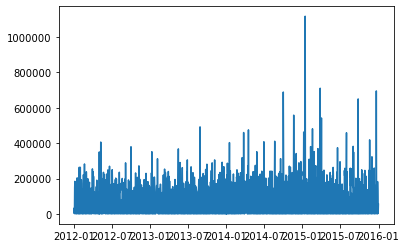

In [32]:
#Recall that df_0019 is daily orders
plt.plot(df_005_train['Order_Demand'])

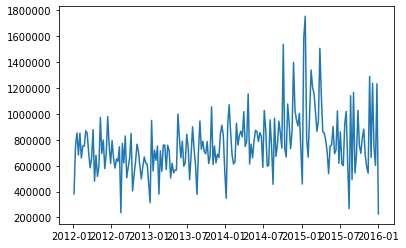

In [33]:
plt.plot(df_005_weekly)

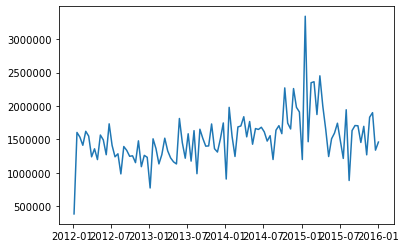

In [34]:
 plt.plot(df_005_biweekly)

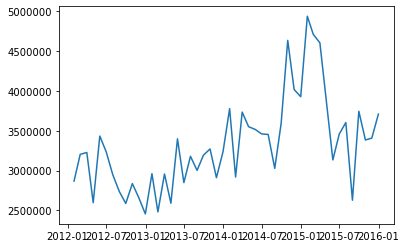

In [35]:
plt.plot(df_005_monthly)

### Series decomposition - weekly, biweekly, monthly

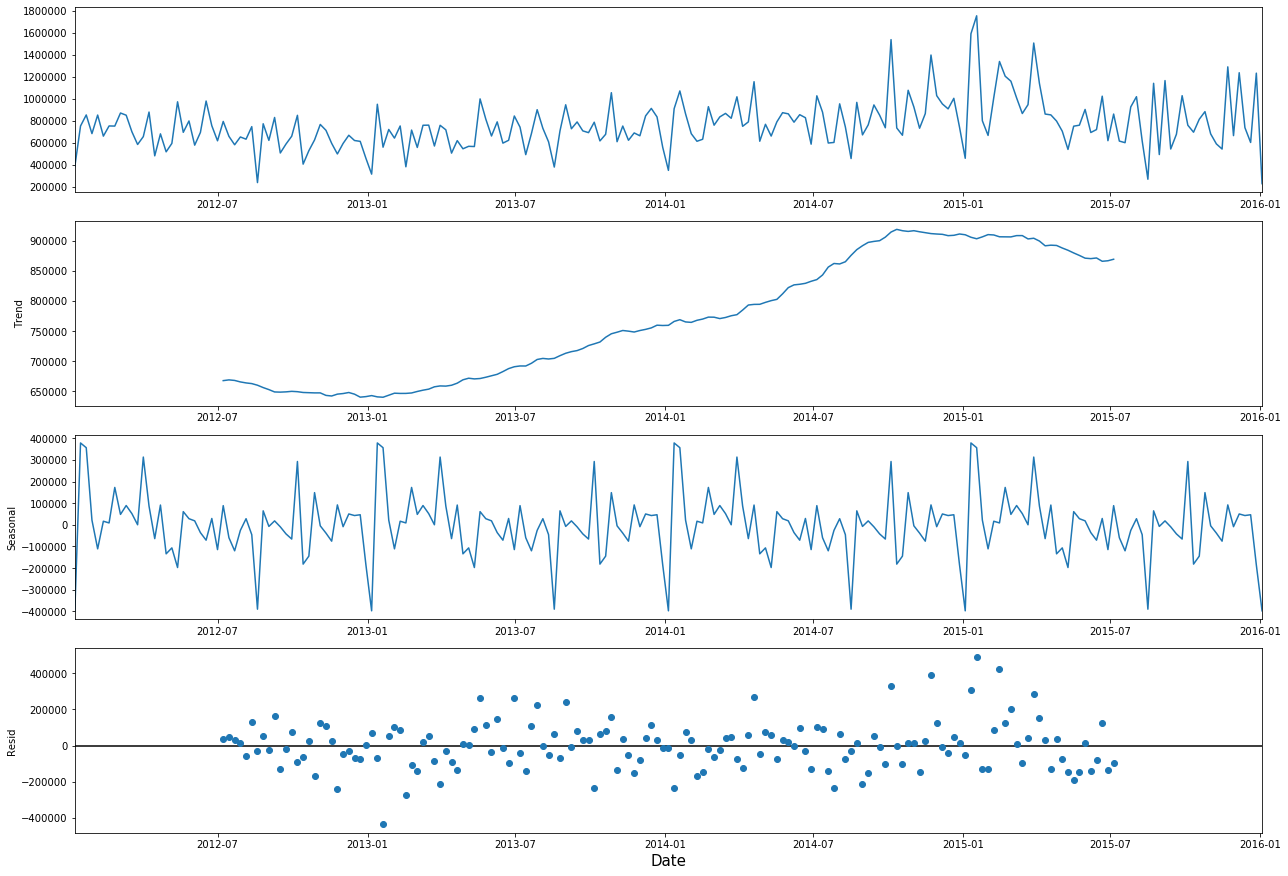

In [36]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by week
y =  df_005_train.resample('W').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

plt.xlabel('Date', fontsize = 15)
plt.show()
fig.savefig('ProdCat005SeriesDecomp.jpg')

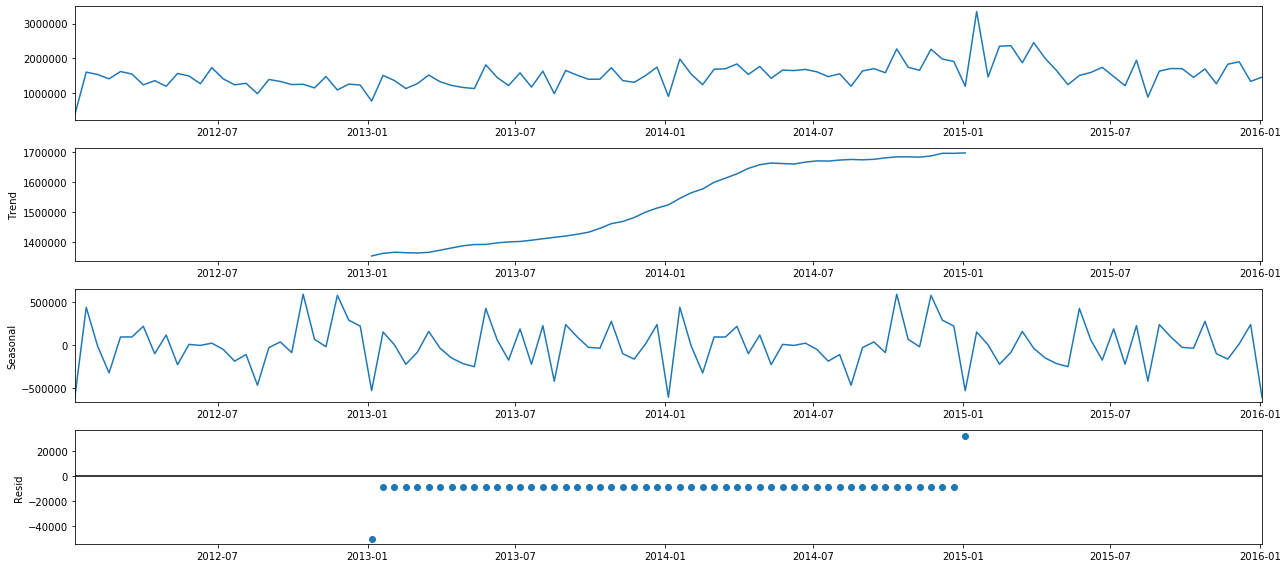

In [37]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by biweekly
y =  df_005_train.resample('2W').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

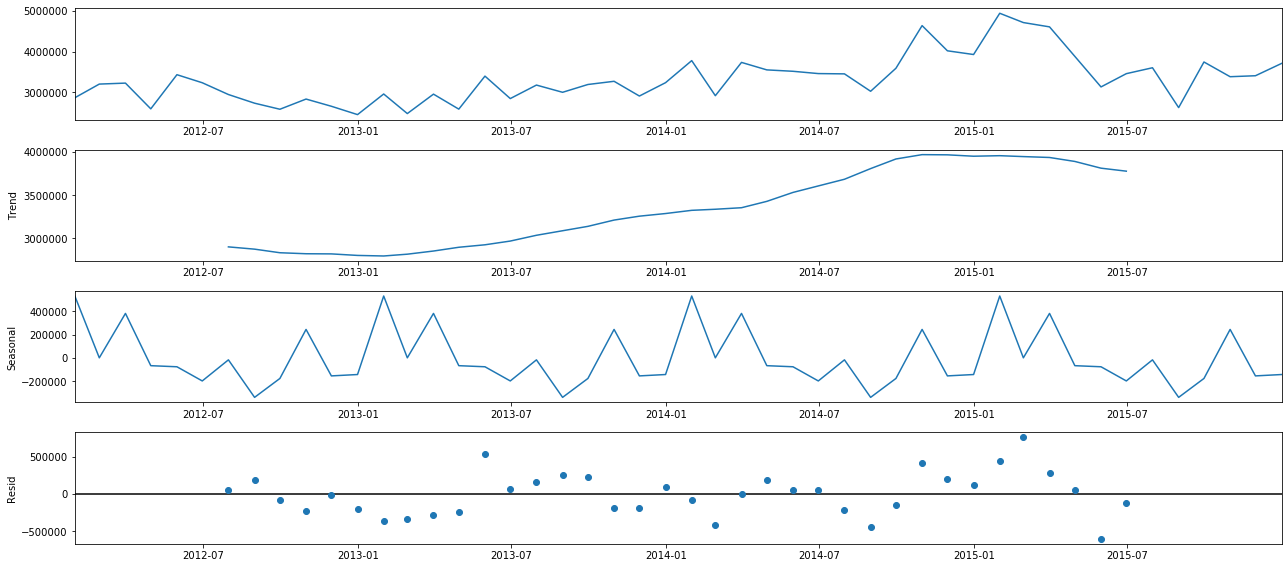

In [38]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by month
y =  df_005_train.resample('M').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [114]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


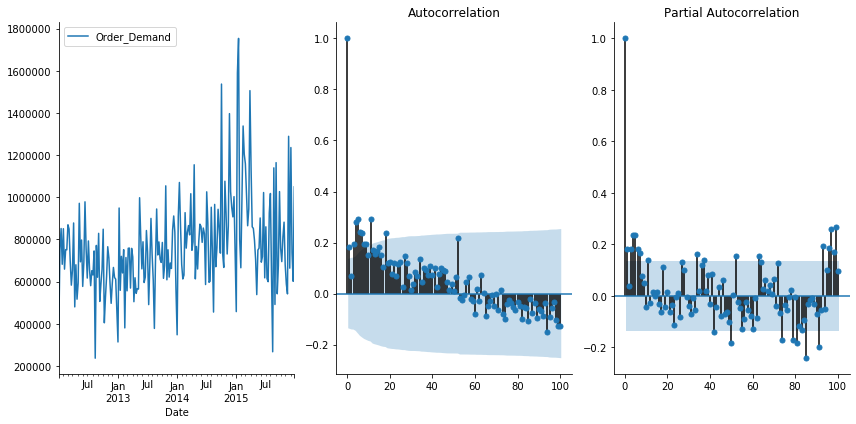

In [115]:
plots(df_005_weekly, lags = 100)

## Modeling

#### Eavluate Weekly

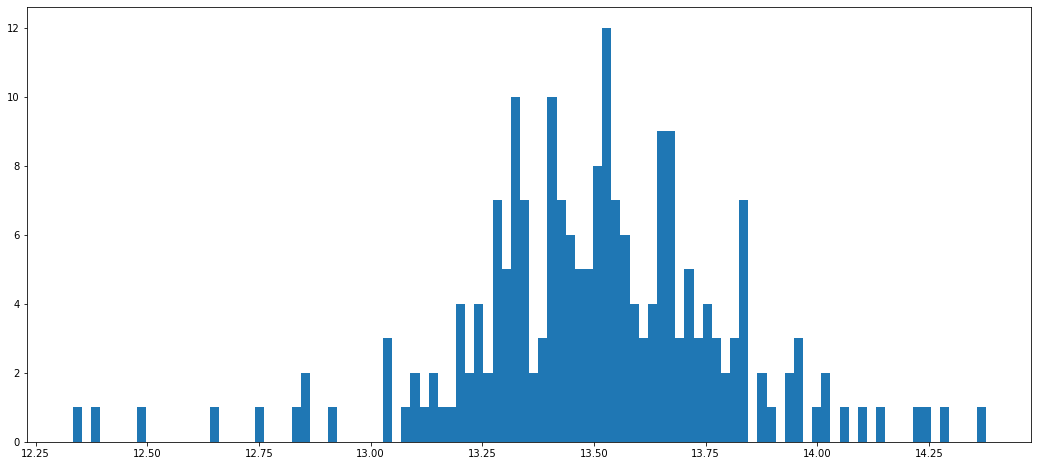

In [41]:
plt.hist(np.array(np.log(df_005_weekly+1)),bins = 100);

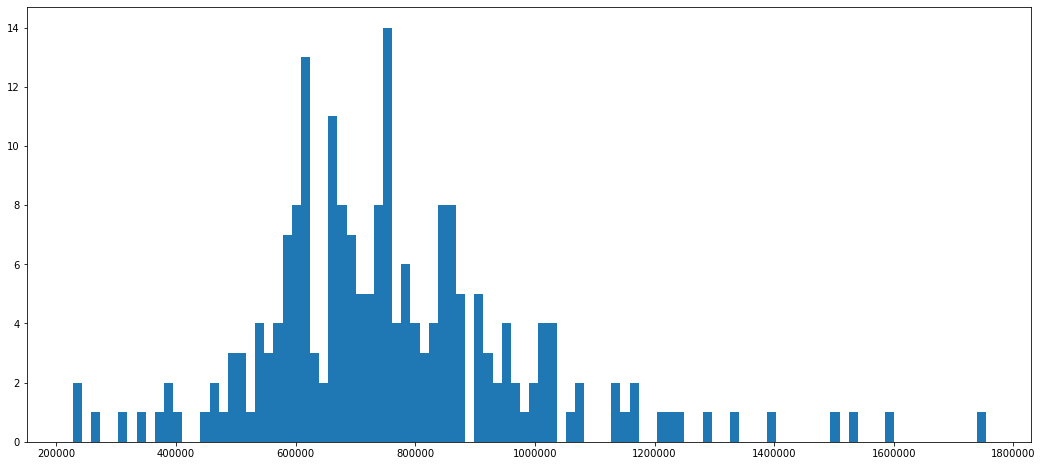

In [42]:
plt.hist(np.array(df_005_weekly),bins = 100);

In [43]:
df_005_weekly

,Order_Demand
Date,
2012-01-08,382765.0
2012-01-15,751385.0
2012-01-22,851925.0
2012-01-29,682245.0
2012-02-05,850900.0
...,...
2015-12-06,1235900.0
2015-12-13,736410.0
2015-12-20,601660.0


### Product Category 005 Model Testing

In [44]:
mod = sm.tsa.statespace.SARIMAX(np.log(df_005_weekly+1), 
                                trend='n', order=(0,1,1),
                                seasonal_order = (1,0,0, 52),
                                enforce_stationarity = True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                 -16.777
Date:                             Sun, 22 Mar 2020   AIC                             39.554
Time:                                     21:29:05   BIC                             49.567
Sample:                                 01-08-2012   HQIC                            43.603
                                      - 01-03-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9037      0.031    -29.066      0.000      -0.965      -0.843
ar.S.L52       0.5195      0.068      7.624      0.000       0.386       0.653
sigma2         0.0631      0.007      9.686      0.000       0.050       0.076
===================================================================================
Ljung-Box (Q):                       33.64   Jarque-Bera (JB):                15.80
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                            -0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#mean error per month:  in a month how many orders am I wrong by?
#plt.plot(np.sum(abs(error)))
#print((np.sum(abs(error)))/error.shape[0]/1000000)

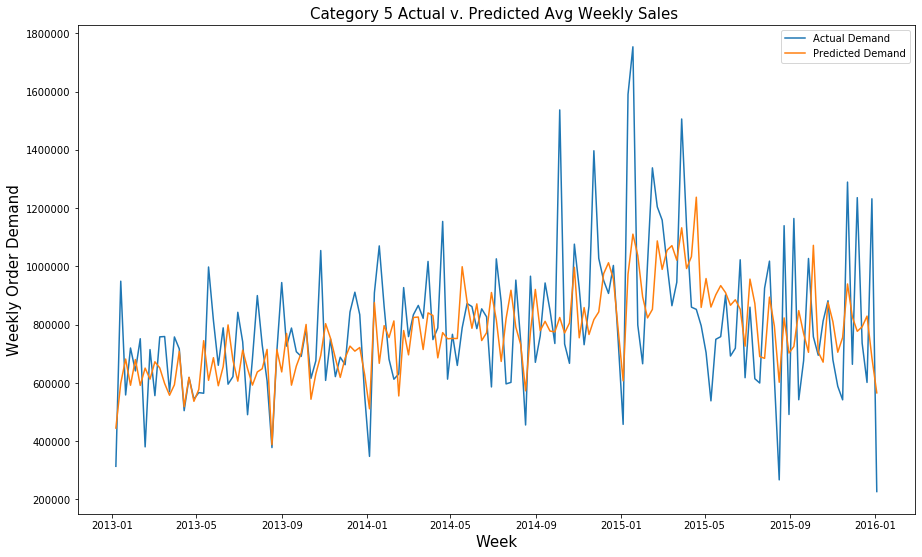

In [46]:
#Blue - actual and Yellow = predicted
y_pred = res.get_prediction()
y_pred.predicted_mean
#plt.plot(np.log(df_0019_weekly['Order_Demand'].iloc[train_index]+1))
fig = plt.figure(figsize  = (15,9))
#plt.plot(df_0019_weekly['Order_Demand'].iloc[train_index])
plt.plot(df_005_weekly['Order_Demand'][52:], label = 'Actual Demand')#.iloc[train_index])
plt.plot(np.exp(y_pred.predicted_mean)[52:], label = 'Predicted Demand')
plt.title('Category 5 Actual v. Predicted Avg Weekly Sales ', fontsize = 15)
plt.ylabel('Weekly Order Demand', fontsize = 15)
plt.xlabel('Week', fontsize = 15)
plt.legend(loc = 'best')
plt.show()
fig.savefig('ProdCat005ActvPredWeekAvg.jpg')

In [47]:
train_index = df_005_weekly.index

Text(0, 0.5, 'Actual')

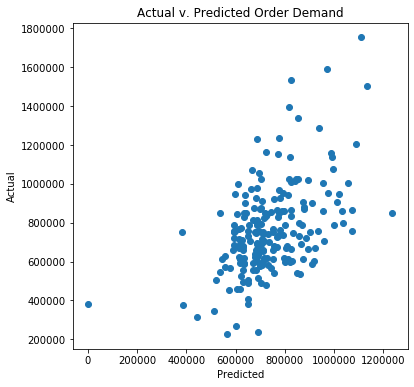

In [48]:
actual = df_005_weekly['Order_Demand'].loc[train_index]
predicted = np.exp(y_pred.predicted_mean[:actual.shape[0]])-1

plt.subplots(figsize = (6,6))
plt.scatter(predicted,actual)
plt.title('Actual v. Predicted Order Demand')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [49]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual, predicted)
print(mae)

152287.70624549023


In [116]:
#actual

In [117]:
# plt.plot(actual)
# plt.plot(predicted)

In [52]:
actual.mean()

763875.2870813397

In [53]:
mae/actual.mean()

0.19936200165259985

In [54]:
actual.std()

229557.3059705058

In [55]:
predicted.mean()

739475.00365532

In [56]:
mae/predicted.mean()

0.20594030290775553

In [57]:
predicted.std()

146963.26703574636

In [58]:
actual.reset_index(drop = True)
y_pred.predicted_mean

Date
2012-01-08     0.000000
2012-01-15    12.855178
2012-01-22    13.194147
2012-01-29    13.350452
2012-02-05    13.371856
                ...    
2015-12-06    13.563323
2015-12-13    13.583097
2015-12-20    13.628299
2015-12-27    13.439321
2016-01-03    13.246049
Freq: W-SUN, Length: 209, dtype: float64

In [59]:
#Look at correlation between the predicted orders and the actual orders. 


pd.concat([actual.reset_index(drop = True)
           ,pd.DataFrame(y_pred.predicted_mean[:actual.shape[0]]).reset_index(drop = True)], 
          axis = 1, ignore_index = True).corr()

,0,1
0,1.000000,0.207824
1,0.207824,1.000000


### Now Evaluate bi-weekly

In [60]:
df_005_biweekly

,Order_Demand
Date,
2012-01-08,382765.0
2012-01-22,1603310.0
2012-02-05,1533145.0
2012-02-19,1411025.0
2012-03-04,1620220.0
...,...
2015-11-08,1268020.0
2015-11-22,1831165.0
2015-12-06,1899710.0


In [61]:
mod = sm.tsa.statespace.SARIMAX(np.log(df_005_biweekly+1), 
                                trend='n', order=(1,1,1),
                                seasonal_order = (1,0,0,26),
                                enforce_stationarity = True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 26)   Log Likelihood                  17.904
Date:                             Sun, 22 Mar 2020   AIC                            -27.808
Time:                                     21:29:07   BIC                            -17.230
Sample:                                 01-08-2012   HQIC                           -23.523
                                      - 01-03-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3231      0.076     -4.227      0.000      -0.473      -0.173
ma.L1         -0.7133      0.093     -7.683      0.000      -0.895      -0.531
ar.S.L26       0.6144      0.083      7.380      0.000       0.451       0.778
sigma2         0.0364      0.006      6.172      0.000       0.025       0.048
===================================================================================
Ljung-Box (Q):                       29.53   Jarque-Bera (JB):                24.46
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.73
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
# #Blue - actual and Yellow = predicted
# y_pred = res.get_prediction()
# y_pred.predicted_mean
# #plt.plot(np.log(df_0019_weekly['Order_Demand'].iloc[train_index]+1))
# plt.plot(df_001_biweekly['Order_Demand'])#.iloc[train_index])
# plt.plot(np.exp(y_pred.predicted_mean))
# plt.title('Actual v. Predicted Avg Weekly Sales ', fontsize = 20)
# plt.ylabel('Weekly Order Demand', fontsize = 20)
# plt.xlabel('Week', fontsize = 20)
# plt.legend(loc = 'lower left')

In [63]:
train_index = df_005_biweekly.index

Text(0, 0.5, 'Actual')

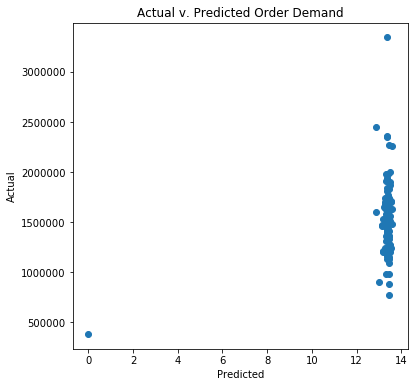

In [64]:
actual = df_005_biweekly['Order_Demand'].loc[train_index]
predicted = y_pred.predicted_mean[:actual.shape[0]]

plt.subplots(figsize = (6,6))
plt.scatter(predicted,actual)
plt.title('Actual v. Predicted Order Demand')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [65]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual, predicted)
print(mae)

1520462.317783247


In [66]:
actual.mean()

1520475.5714285714

In [67]:
actual.reset_index(drop = True)
y_pred.predicted_mean

Date
2012-01-08     0.000000
2012-01-15    12.855178
2012-01-22    13.194147
2012-01-29    13.350452
2012-02-05    13.371856
                ...    
2015-12-06    13.563323
2015-12-13    13.583097
2015-12-20    13.628299
2015-12-27    13.439321
2016-01-03    13.246049
Freq: W-SUN, Length: 209, dtype: float64

In [68]:
#Look at correlation between the predicted orders and the actual orders. 
#The higher THAT correlation, the better the model
#.27 is not too bad

pd.concat([actual.reset_index(drop = True)
           ,pd.DataFrame(y_pred.predicted_mean[:actual.shape[0]]).reset_index(drop = True)], 
          axis = 1, ignore_index = True).corr()

,0,1
0,1.000000,0.290223
1,0.290223,1.000000


### Now Try Monthly

In [69]:
mod = sm.tsa.statespace.SARIMAX(np.log(df_005_monthly+1), 
                                trend='n', order=(1,0,1),
                                seasonal_order = (0,1,0,12),
                                enforce_stationarity = True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                  19.889
Date:                             Sun, 22 Mar 2020   AIC                            -33.778
Time:                                     21:29:07   BIC                            -29.028
Sample:                                 01-31-2012   HQIC                           -32.120
                                      - 12-31-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8609      0.116      7.392      0.000       0.633       1.089
ma.L1         -0.4000      0.283     -1.411      0.158      -0.956       0.155
sigma2         0.0190      0.005      3.872      0.000       0.009       0.029
===================================================================================
Ljung-Box (Q):                       29.78   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.72   Prob(JB):                         0.58
Heteroskedasticity (H):               1.70   Skew:                            -0.43
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

No handles with labels found to put in legend.


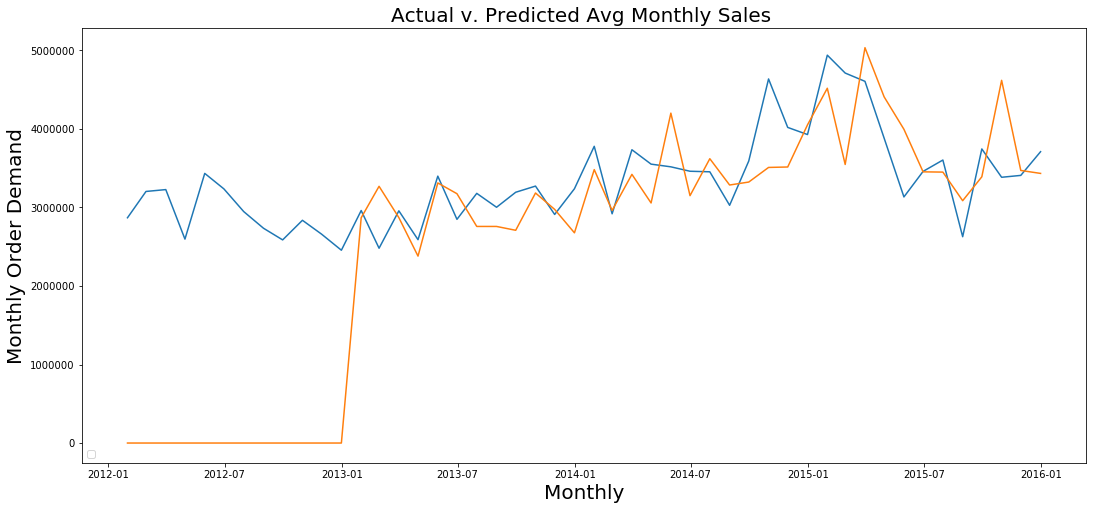

In [70]:
#Blue - actual and Yellow = predicted
y_pred = res.get_prediction()
y_pred.predicted_mean
#plt.plot(np.log(df_0019_weekly['Order_Demand'].iloc[train_index]+1))
plt.plot(df_005_monthly['Order_Demand'])#.iloc[train_index])
plt.plot(np.exp(y_pred.predicted_mean))
plt.title('Actual v. Predicted Avg Monthly Sales ', fontsize = 20)
plt.ylabel('Monthly Order Demand', fontsize = 20)
plt.xlabel('Monthly', fontsize = 20)
plt.legend(loc = 'lower left')

In [71]:
train_index = df_005_monthly.index

Text(0, 0.5, 'Actual')

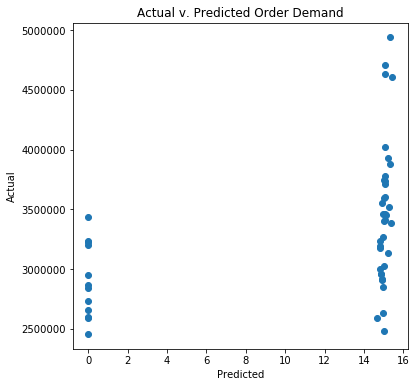

In [72]:
actual = df_005_monthly['Order_Demand'].loc[train_index]
predicted = y_pred.predicted_mean[:actual.shape[0]]

plt.subplots(figsize = (6,6))
plt.scatter(predicted,actual)
plt.title('Actual v. Predicted Order Demand')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [73]:
actual.reset_index(drop = True)
y_pred.predicted_mean

Date
2012-01-31    0.000000e+00
2012-02-29    3.301724e-07
2012-03-31    6.168620e-07
2012-04-30    8.638293e-07
2012-05-31    1.071609e-06
2012-06-30    1.256684e-06
2012-07-31    1.414696e-06
2012-08-31    1.548649e-06
2012-09-30    1.662305e-06
2012-10-31    1.758909e-06
2012-11-30    1.844119e-06
2012-12-31    1.916046e-06
2013-01-31    1.486932e+01
2013-02-28    1.500008e+01
2013-03-31    1.487004e+01
2013-04-30    1.468272e+01
2013-05-31    1.501310e+01
2013-06-30    1.497081e+01
2013-07-31    1.483006e+01
2013-08-31    1.483003e+01
2013-09-30    1.481216e+01
2013-10-31    1.497366e+01
2013-11-30    1.490584e+01
2013-12-31    1.480015e+01
2014-01-31    1.506304e+01
2014-02-28    1.490134e+01
2014-03-31    1.504558e+01
2014-04-30    1.493299e+01
2014-05-31    1.525085e+01
2014-06-30    1.496294e+01
2014-07-31    1.510219e+01
2014-08-31    1.500510e+01
2014-09-30    1.501654e+01
2014-10-31    1.507100e+01
2014-11-30    1.507258e+01
2014-12-31    1.521472e+01
2015-01-31    1.532358e

In [74]:
#Look at correlation between the predicted orders and the actual orders. 
pd.concat([actual.reset_index(drop = True)
           ,pd.DataFrame(y_pred.predicted_mean[:actual.shape[0]]).reset_index(drop = True)], 
          axis = 1, ignore_index = True).corr()

,0,1
0,1.000000,0.436997
1,0.436997,1.000000


### Sarimax Forecast

In [75]:
df_005_train = df_005[(df_005.index >'2012-01-01') & (df_005.index<'2015-12-27')]
df_005_train.tail()

,Order_Demand
Date,
2015-12-22,122400.0
2015-12-23,20100.0
2015-12-24,100325.0
2015-12-25,111600.0
2015-12-26,0.0


In [76]:
#resample by week
df_005_weekly = df_005_train.resample('W').sum()

In [77]:
df_005_weekly.index

DatetimeIndex(['2012-01-08', '2012-01-15', '2012-01-22', '2012-01-29',
               '2012-02-05', '2012-02-12', '2012-02-19', '2012-02-26',
               '2012-03-04', '2012-03-11',
               ...
               '2015-10-25', '2015-11-01', '2015-11-08', '2015-11-15',
               '2015-11-22', '2015-11-29', '2015-12-06', '2015-12-13',
               '2015-12-20', '2015-12-27'],
              dtype='datetime64[ns]', name='Date', length=208, freq='W-SUN')

#### Product Category 005 Model Testing

In [78]:
mod = sm.tsa.statespace.SARIMAX(np.log(df_005_weekly+1), 
                                trend='n', order=(1,1,1),
                                seasonal_order = (1,1,0, 52),
                                enforce_stationarity = True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                 -12.602
Date:                             Sun, 22 Mar 2020   AIC                             33.205
Time:                                     21:29:12   BIC                             45.378
Sample:                                 01-08-2012   HQIC                            38.149
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1707      0.092     -1.861      0.063      -0.350       0.009
ma.L1         -0.8482      0.051    -16.519      0.000      -0.949      -0.748
ar.S.L52      -0.3654      0.086     -4.227      0.000      -0.535      -0.196
sigma2         0.0650      0.009      7.368      0.000       0.048       0.082
===================================================================================
Ljung-Box (Q):                       25.51   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.96   Prob(JB):                         0.31
Heteroskedasticity (H):               1.53   Skew:                             0.02
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:

predict1 = res.get_forecast(steps = 56)
                
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))-1
pred_vals1 = np.exp(predict1.predicted_mean)

In [80]:
df_005_test = df_005_test.resample('W').sum()

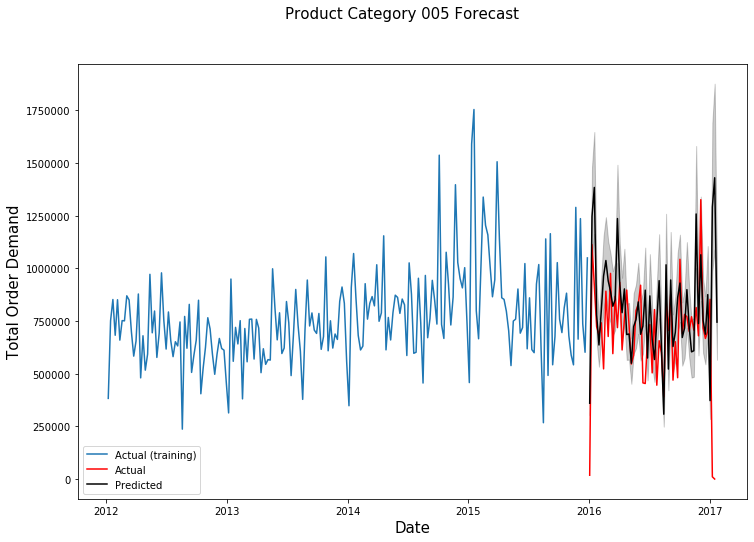

In [81]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)


low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
# pred_times2 = pred_ci2.index

# plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(df_005_weekly.index, df_005_weekly['Order_Demand'].values, label='Actual (training)')

plt.plot(df_005_test.index, df_005_test['Order_Demand'].values, c='r', label='Actual')
plt.plot(pred_vals1.index, pred_vals1.values, c='k', label='Predicted')
plt.legend(loc = "lower left")


plt.fill_between(pred_ci1.index, low_values, high_values, color='k', alpha=0.2)
fig.suptitle('Product Category 005 Forecast', fontsize = 15 )
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Total Order Demand', fontsize = 15);
fig.savefig('ProdCat005FORECAST.jpg')

## Find Mean Absolute error for predictions and actual results

#### Define y_pred (Predicted) for MAE

In [82]:
predict1

In [83]:
predict1

In [84]:
len(pred_vals1)

56

In [85]:
y_pred = pred_vals1[:-1]

In [86]:
len(y_pred)

55

In [87]:
type(y_pred)

pandas.core.series.Series

In [88]:
#y_pred

#### Define y_true (Actuals) for MAE 

In [89]:
df_005_test.shape

(55, 1)

In [90]:
type(df_005_test)

pandas.core.frame.DataFrame

In [91]:
y_true = df_005_test.Order_Demand
y_true.head()

Date
2016-01-03      18000.0
2016-01-10    1112580.0
2016-01-17     919430.0
2016-01-24     723120.0
2016-01-31     683475.0
Freq: W-SUN, Name: Order_Demand, dtype: float64

In [92]:
len(y_true)

55

In [118]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(mae)

211529.32899997948


In [94]:
y_true.mean()

691643.7272727273

In [95]:
mae/y_true.mean()

0.3058356790627984

In [96]:
y_true.std()

240131.5683799392

In [97]:
y_pred.mean()

812688.0459776927

In [98]:
mae/y_pred.mean()

0.2602835492006064

In [99]:
y_pred.std()

238749.54098360767

In [100]:
y_pred - y_true

2016-01-03    3.417887e+05
2016-01-10    1.340561e+05
2016-01-17    4.644272e+05
2016-01-24    5.542979e+04
2016-01-31   -4.735464e+04
2016-02-07    5.566159e+04
2016-02-14    4.405694e+05
2016-02-21    1.455883e+05
2016-02-28    2.641226e+05
2016-03-06   -8.533436e+04
2016-03-13    2.248931e+05
2016-03-20   -1.546035e+04
2016-03-27    5.176977e+05
2016-04-03   -8.256945e+03
2016-04-10    1.770203e+05
2016-04-17    1.433273e+05
2016-04-24   -2.110182e+05
2016-05-01   -4.321973e+04
2016-05-08    3.833468e+03
2016-05-15    1.358912e+05
2016-05-22   -4.218486e+04
2016-05-29    9.840915e+03
2016-06-05   -2.326820e+05
2016-06-12    2.691895e+05
2016-06-19    4.432112e+05
2016-06-26   -9.787899e+04
2016-07-03    1.358981e+05
2016-07-10    1.593041e+05
2016-07-17   -2.370486e+05
2016-07-24    3.038573e+05
2016-07-31    2.848977e+05
2016-08-07    2.574123e+04
2016-08-14   -8.252173e+04
2016-08-21    1.662299e+05
2016-08-28   -1.831678e+05
2016-09-04    6.839307e+04
2016-09-11    1.595872e+05
2

In [101]:
MAE = abs((y_pred - y_true)).mean()
MAE

211529.32899997948

In [102]:
#Root Mean Squared Error
(((y_pred - y_true)**2).mean())**.5

336502.665381002

In [103]:
#Cross valiadation for time series

from sklearn.model_selection import TimeSeriesSplit
#Note that had to specify n_splits = 2 to ensure differencing didn't cause indices failure
tscv = TimeSeriesSplit(n_splits = 2)


for train_index, test_index in tscv.split(df_005_weekly):
    #print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = df_0019_weekly.iloc[train_index]['Order_Demand'],df_0019_weekly.iloc[test_index]['Order_Demand']
    #y_train, y_test = y[train_index], y[test_index]
    #print(y_train)
    #NOTE the train set expands and the test set gets smaller    
    #had to take out this from SARIMAx , seasonal_order = (1,1,0,52
    mod = sm.tsa.statespace.SARIMAX(np.log(y_train+1), trend='n', order=(1,3,3),seasonal_order = (1,1,0,52))
    res = mod.fit(disp=False)
    print(res.summary())

NameError: name 'df_0019_weekly' is not defined

#### Now try bi-weekly

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Note that had to specify n_splits = 2 to ensure differencing didn't cause indices failure
tscv = TimeSeriesSplit(n_splits = 2)


for train_index, test_index in tscv.split(df_0019_biweekly):
    #print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = df_0019_biweekly.iloc[train_index]['Order_Demand'],df_0019_biweekly.iloc[test_index]['Order_Demand']
    #y_train, y_test = y[train_index], y[test_index]
    #print(y_train)
    #NOTE the train set expands and the test set gets smaller    
    #had to take out this from SARIMAx , seasonal_order = (1,1,0,52)
    mod = sm.tsa.statespace.SARIMAX(np.log(y_train+1), trend='n', order=(0,1,1),seasonal_order = (1,1,0,26))
    res = mod.fit(disp=False)
    print(res.summary())

### Now try monthly

In [ ]:
#pd.DataFrame(outcomes).sort_values(by = 2).head(10)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
#Note that had to specify n_splits = 2 to ensure differencing didn't cause indices failure
tscv = TimeSeriesSplit(n_splits = 2)


for train_index, test_index in tscv.split(df_0019_monthly):
    #print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = df_0019_monthly.iloc[train_index]['Order_Demand'],df_0019_monthly.iloc[test_index]['Order_Demand']
    #y_train, y_test = y[train_index], y[test_index]
    #print(y_train)
    #NOTE the train set expands and the test set gets smaller    
    #had to take out this from SARIMAx , seasonal_order = (1,1,0,52
    mod = sm.tsa.statespace.SARIMAX(y_train, trend='n', order=(0,2,0),seasonal_order = (1,2,2,12))
    res = mod.fit(disp=False)
    print(res.summary())

In [ ]:
#This is to be used for OUT OF SAMPLE testing

# Fit the model recall that c means constant
mod = sm.tsa.statespace.SARIMAX(np.log(df_0019_weekly+1), trend='ct', order=(1,1,0), 
                                seasonal_order = (0,3,0,52))
res = mod.fit(disp=False)
res.summary()

For the trend param, recall that  
'c' indicates a constant (i.e. adegree zero component of the trend polynomial),  
't' indicates a linear trend with time,  
'ct' is both.

In [ ]:
# Fit the model recall that c means constant
# mod = sm.tsa.statespace.SARIMAX((y_train+1), trend='n', order=(0,1,1), seasonal_order = (1,0,0,52))
# res = mod.fit(disp=False)
# res.summary()

In [ ]:
#Blue - actual and Yellow = predicted
y_pred = res.get_prediction()
y_pred.predicted_mean
#plt.plot(np.log(df_0019_weekly['Order_Demand'].iloc[train_index]+1))
plt.plot(df_0019_monthly['Order_Demand'].iloc[train_index])
plt.plot((y_pred.predicted_mean))
plt.title('Actual v. Predicted Avg Weekly Sales ', fontsize = 35)
plt.ylabel('Weekly Order Demand in 100k', fontsize = 35)
plt.xlabel('Week', fontsize = 35)
plt.legend(loc = 'lower left')

In [ ]:
#calculating back test

actual = df_0019_monthly['Order_Demand'].iloc[train_index]
change_in_actual = np.array(actual.iloc[1:])-np.array(actual.iloc[0:-1])

In [ ]:
predicted = y_pred.predicted_mean
change_in_predicted= np.array(predicted[1:]) - np.array(predicted[0:-1]) 

In [ ]:
#are we going to increase or decrease inventory??
error = np.array(change_in_predicted-change_in_actual)

plt.plot(np.cumsum(abs(error)))
#y axis is cumulative error and x axis is weeks

In [ ]:
#plt.plot(np.log(df_0019_weekly['Order_Demand'].iloc[train_index]+1))
plt.plot(change_in_actual*3)
plt.plot((change_in_predicted))
plt.title('Actual v. Predicted Avg Weekly Sales ', fontsize = 35)
plt.ylabel('Weekly Order Demand in 100k', fontsize = 35)
plt.xlabel('Week', fontsize = 35)
plt.legend(loc = 'lower left')

In [ ]:
#mean error per month:  in a month how many orders am I wrong by?

#plt.plot(np.sum(abs(error)))
print((np.sum(abs(error)))/error.shape[0]/1000000)

In [ ]:
error.shape


In [ ]:
#Blue - actual and Yellow = predicted
y_pred = res.get_prediction()
y_pred.predicted_mean



#calculating back test

actual = df_0019_weekly['Order_Demand'].iloc[train_index]
change_in_actual_weekly = np.array(actual.iloc[1:])-np.array(actual.iloc[0:-1])

predicted = y_pred.predicted_mean
change_in_predicted_weekly= np.array(predicted[1:]) - np.array(predicted[0:-1]) 



#are we going to increase or decrease inventory??
error_weekly = np.array(change_in_predicted_weekly-change_in_actual_weekly)

#plt.plot(np.cumsum(abs(error)))
#y axis is cumulative error and x axis is weeks




plt.plot(actual)


In [ ]:
print((np.sum(abs(error_weekly)))/error_weekly.shape[0]*4.5/1000000)

In [ ]:
plt.plot(error_weekly)

**Use multiplicative models when the percentage change of our data is more important than the absolute value change** (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. If our seasonality and fluctuations are stable, we likely have an additive model.

### NOTE TO SELF on ARIMA
#### Recall that:

An ARIMA model is characterized by 3 terms:  
p, d, q where these three parameters account for seasonality (p), trend (d), and noise in data (q):  

**p** is the order of the AR term (number of lags of Y to be used as predictors).  
    If it snowed for the last wee, it is likely it will snow tomorrow.  
    
**q** is the order of the MA term (moving average).  

**d** is the number of differencing required to make the time series stationary.  
    If already stationary d=0.  
    But when dealing with SEASONALITY, it is best to incorporate it as 's'. 
    ARIMA(p,d,q)(P,D,Q)s. Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series.  
    4:quarter, 12:yearly etc.  
    
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

### Grid Search

Since ARIMA has hyper params that can be tuned, the objective here is to find the best params using Grid Search.

In [ ]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
y

In [ ]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.
outcomes = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            outcomes.append([param, param_seasonal, results.aic])

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        

In [ ]:
pd.DataFrame(outcomes).sort_values(by = 2)

### Fit the Model

In [ ]:
#Fit the model with the best params.
#ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.5164122018646


#The above output suggests that ARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value: 960.516
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

#### Interpreting the table:

**coeff:** Shows weight/impotance how each feature impacts the time series.  
**Pvalue:** Shows the significance of each feature weight. Can test hypothesis using this.  
    If p value is <.05 then they are statitically significant.

**Refresher on null hyp and pvalues.**
    By default we take the null hyp as 'there is no relationship bw them'.  
    If p value < .05 (significance level) then you reject the Null Hypthesis.  
    If p value > .05 , then you fail to reject the Null Hypothesis.

So, if the p-value is < .05 then there is a relationship between the response and predictor.  
Hence, significant.

In [ ]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

### Model Validation

In [ ]:
#Get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 
#but the previous line shows how it fits to the data.

#false is when using the entire history.
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False)

#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. 
#The Blue/purple thicker plot shows the confidence level in the forecasts.

### Forecast Accuracy

In [ ]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

In [ ]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.

Next steps include checking and modeling demand by category type.

#### Note to Self:  Remember, Product_Code, Warehouse, Product_Category are just that = Categorical

In [ ]:
#Does a feature need log transformation? NO
#Does the target need to be transformed?  If so, does it need to be transformed back?
#It depends on the story you are telling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns = x_data.columns)
x_val = pd.DataFrame(scaler.transform(x_val), columns = x_data.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns = x_data.columns)

In [ ]:
type(x_train)